In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
!pip install transformers
!pip install sentencepiece
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.5 MB/s

In [4]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import os
import json

In [381]:
import os
import json
import re
from zipfile import ZipFile

cond = re.compile('[가-힣]+')

def get_data_from_zip(zip_name):
    zip_file_path = '/content/drive/MyDrive/jolnon/' + zip_name + '.zip'
    extract_path = '/content/' + zip_name

    # zip 파일 압축 해제
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    result = []
    for name in os.listdir(path=extract_path):
        file_path = os.path.join(extract_path, name)
        if os.path.isdir(file_path):
            for name in os.listdir(path=file_path):
                with open(file_path + '/' + name, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    valid = []
                    for d in data['content'].split('\n'):
                        res = []
                        for word in d.split(' '):
                            if cond.match(word) != None:
                                res.append(word)
                        d = ' '.join(res)
                        if d and not d.replace(' ', '').isdecimal():
                            valid.append(d)
                    result.append('\n'.join([data['title']] + valid))
        else:
            with open(extract_path + '/' + name, 'r', encoding='utf-8') as f:
                data = json.load(f)
                valid = []
                for d in data['content'].split('\n'):
                    res = []
                    for word in d.split(' '):
                        if cond.match(word) != None:
                            res.append(word)
                    d = ' '.join(res)
                    if d and not d.replace(' ', '').isdecimal():
                        valid.append(d)
                result.append('\n'.join([data['title']] + valid))
    return result


In [382]:
import random
random.seed(42)
galleries = ['animal','tree']#,'ktwiz','kartriderdrift','skwyverns_new1','ncdinos','samsunglions_new','doosanbears_new1','giants_new2','sh_new','lgtwins_new','tigers_new']
dataset = []
for e in galleries:
  dataset.append([get_data_from_zip(e)])
cocktail = []
for data in dataset:
  for sen in data:
    cocktail+=sen

In [383]:
def remove_words(sentence, word):
    return ' '.join([w for w in sentence.split() if w != word])
stopwords = ['-dc', 'official', 'App', '이미지' ,'순서','저장']#['ㅋㅋ', 'ex', '나는', 'on', '이미지', '순서', '오늘', '일단', 'and', '이야', '그리고', '내일', '그냥', '000', '조금', '살짝', 'ㅇㅇ', 'ㅈㄱㄴ', '있음', '이거', '내가', '칵하하하', '칵하핫', '근데', '지듣노', 'youtube ', '야스중', '우흥', '한다', 'ㅎㅎ', 'ㅠㅠ', '로오오오오오옹', '하고', '아침', '것도', '추천', '혹시', '새낀데', '같다']
for i in range(len(cocktail)):
  for j in range(len(stopwords)):
    cocktail[i] = remove_words(cocktail[i],stopwords[j])

In [384]:
import collections

def remove_top_n_words(data, n):
    words = [word for sentence in data for word in sentence.split(' ')]
    word_count = collections.Counter(words)
    top_n_words = [word for word, _ in word_count.most_common(n)]
    for i in range(len(data)):
        for word in top_n_words:
            if word=='':
                continue
            data[i] = remove_words(data[i], word)
    return data

def remove_empty_sentences(cocktail, real_labels):
  indices = [i for i, sentence in enumerate(cocktail) if sentence.strip() != '']
  cocktail = [cocktail[i] for i in indices]
  real_labels = [real_labels[i] for i in indices]
  return cocktail, real_labels


In [385]:
real_labels = []
for i in range(len(dataset)):
  real_labels += [i] * len(dataset[i][0])
cocktail = remove_top_n_words(cocktail, 0)
cocktail, real_labels = remove_empty_sentences(cocktail, real_labels)

In [386]:
from transformers import AutoModel, AutoTokenizer
from umap import UMAP
# umap_model = UMAP(random_state=42)
# umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', random_state=42)
model = AutoModel.from_pretrained("klue/roberta-large")
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [387]:
class CustomTokenizer:
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer
  # def __call__(self, target):
  #   return self.tokenizer.tokenize(target)
  def __call__(self, target):
    tokens = self.tokenizer.tokenize(target)
    if isinstance(tokens[0], str):
      indices = [i for i, token in enumerate(tokens) if not token.startswith('##')]
      tokens = [tokens[i] for i in indices]
    elif isinstance(tokens[0][0], str):
      for j in range(len(tokens)):
        indices = [i for i, token in enumerate(tokens[j]) if not token.startswith('##')]
        tokens[j] = [tokens[j][i] for i in indices]
    return tokens

In [388]:
from sklearn.feature_extraction.text import TfidfVectorizer

custom_tokenizer = CustomTokenizer(tokenizer)
# vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_features=3000)
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=3000)

In [389]:
# from umap import UMAP
# from hdbscan import HDBSCAN

# umap_model = UMAP(n_neighbors=5, n_components=5, metric='cosine', low_memory=False)
# hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)

In [390]:
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
bertopic_model_embed_token = BERTopic(language='multilingual',
                          nr_topics=100,
                          top_n_words=1)
# bertopic_model_embed_token = BERTopic(embedding_model=model,
#                                       # umap_model=umap_model,
#                                       # hdbscan_model=hdbscan_model,
#                                       vectorizer_model=vectorizer,
#                                       ctfidf_model=ctfidf_model,
#                                       nr_topics=100,
#                                       top_n_words=3,
#                                       calculate_probabilities=False)
topics, _ = bertopic_model_embed_token.fit_transform(cocktail)

In [391]:
topic_info = bertopic_model_embed_token.get_topic_info()
number_of_topics = len(topic_info) - 1
print(f"생성된 주제의 수: {number_of_topics}")
lst = []
for index, row in topic_info.iterrows():
    topic_num = row['Topic']
    if topic_num != -1:
        topic_name = row['Name']
        pure_topic_name = "_".join(topic_name.split("_")[1:])
        lst.append(pure_topic_name)
for i in lst:
  print(i)

생성된 주제의 수: 99
로보쿤
햄스터
꽃이
물을
신엽
김나나
어디서
잎이
이거
에어컨
식물등
귀엽다
jpg
고양이
병원
쥐친구
터널
핸들링
사료
흙은
거미줄
이름이
이름이
미분
잠자는쥐
냄새
동물이
나무
뿌리
쳇바퀴
쥐가
코코넛
식물
오르비
토마토
우리집
화장실
모래
서울
놔라
무름병
케이지
비둘기
부동산
뚱땡정글
맛있음
식물
로즈마리
유혈목이
캄차쿠노름표
플로리다
입제
기니피그
알로카시아
전면부를
일베
가지치기
뽀뽀
수컷이
햄스터
사진
올리브
얼음
유통기한
강아지
아프리칸
그린닷은
딸기
자고
블루베리
해씨
플라스틱
높이
냉장고를
생태계교란
나무위키
멍청햄
ㅇㅇ
유튜브
돼지
사진
벌레인지
낫나요
버섯
흑설기와
공간이
피드클릭
거북이
김나나
식쇼
올해
강아지
수명이
개구리
갤러
죽은걸까요
레몬
여잔
누가이김


In [392]:
table = [[0 for r in range(2)] for t in range(number_of_topics)]

for j in range(number_of_topics):
  for i in range(len(topics)):
    if topics[i]==j:
      table[j][real_labels[i]]+=1
print(table)

[[1106, 788], [1402, 2], [9, 518], [23, 295], [51, 196], [74, 156], [61, 158], [1, 175], [65, 98], [49, 76], [1, 114], [81, 24], [100, 3], [87, 15], [90, 11], [100, 0], [50, 45], [86, 8], [75, 17], [4, 85], [17, 71], [12, 74], [0, 73], [24, 47], [67, 2], [36, 29], [61, 2], [5, 58], [0, 61], [47, 9], [53, 0], [42, 11], [0, 52], [10, 40], [3, 46], [37, 12], [43, 4], [43, 3], [15, 30], [27, 14], [8, 31], [36, 3], [33, 0], [14, 19], [29, 3], [22, 10], [1, 31], [0, 32], [30, 1], [16, 13], [11, 17], [2, 25], [26, 1], [1, 25], [1, 25], [26, 0], [0, 25], [21, 3], [23, 0], [22, 0], [21, 1], [0, 21], [0, 20], [3, 17], [17, 3], [0, 19], [0, 18], [5, 13], [17, 0], [4, 13], [17, 0], [5, 12], [7, 9], [16, 0], [15, 1], [13, 2], [13, 2], [14, 1], [9, 6], [14, 1], [5, 10], [6, 8], [4, 9], [0, 13], [13, 0], [5, 8], [12, 0], [10, 2], [9, 3], [0, 11], [2, 9], [6, 5], [11, 0], [7, 4], [0, 10], [0, 10], [0, 10], [6, 4], [10, 0]]


In [393]:
### Reducing outliers
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="c-tf-idf", threshold=0.1)
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="distributions")

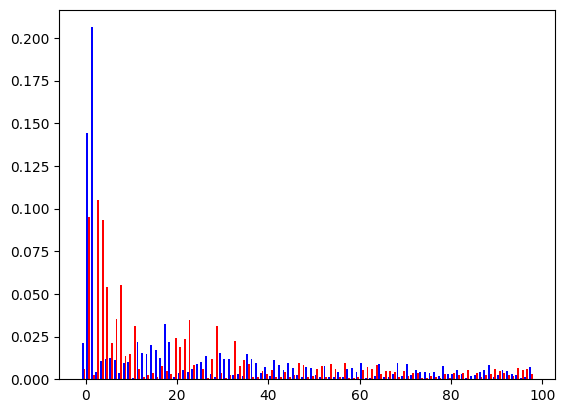

In [394]:
import matplotlib.pyplot as plt

colors = ["#0000FF", "#FF0000"]

data = [[] for _ in range(len(dataset))]
for j in range(len(dataset)):
    data[j] = [topics[i] for i in range(len(real_labels)) if real_labels[i] == j]
    # plt.hist(data[j], bins=number_of_topics, color=colors[j], histtype='bar')
    # plt.show()

plt.hist(data, bins=number_of_topics, color=colors, histtype='bar', density=True)
plt.show()

In [395]:
import numpy as np
npdata = [[] for _ in range(len(dataset))]
for j in range(len(dataset)):
  npdata[j] = np.array([0] * (number_of_topics + 1), dtype=np.float32)
  for k in range(len(data[j])):
    npdata[j][data[j][k] + 1] += 1
  npdata[j] /= npdata[j].sum()

In [396]:
topic_ = [[], []]
threshold = 5
for k in range(number_of_topics):
  ratio = max((npdata[0][k] + 1e-12) / (npdata[1][k] + 1e-12), (npdata[1][k] + 1e-12) / (npdata[0][k] + 1e-12))
  if ratio > threshold:
    if npdata[0][k] > npdata[1][k]:
      topic_[0].append((k - 1, npdata[0][k], npdata[1][k]))
    else:
      topic_[1].append((k - 1, npdata[0][k], npdata[1][k]))

for k in range(len(topic_)):
  topic_[k].sort(key=lambda x: x[k + 1], reverse=True)
  for j, v0, v1 in topic_[k]:
    print('\t'.join([x[0] for x in bertopic_model_embed_token.get_topic(j)]), j, v0, v1, sep='\t')
  print()

햄스터	1	0.20628385	0.002371776
핸들링	17	0.032286026	0.004842376
사료	18	0.021776814	0.0032611918
병원	14	0.019934995	0.0036564877
쥐친구	15	0.017226435	0.0012847119
jpg	12	0.015384615	0.0013835359
고양이	13	0.014951246	0.0025694238
동물이	26	0.013651137	0.00079059193
코코넛	31	0.012026003	0.002371776
화장실	36	0.01191766	0.00148236
쥐가	30	0.011700975	0.00088941597
케이지	41	0.0114842905	0.0010870639
자고	68	0.009642471	0.0013835359
모래	37	0.009534128	0.001185888
뚱땡정글	44	0.009425785	0.001185888
잠자는쥐	24	0.008775732	0.000296472
해씨	70	0.008775732	0.0016800079
비둘기	42	0.008342362	0.0012847119
기니피그	52	0.0076923077	0.0010870639
유혈목이	48	0.0070422534	0.0010870639
수컷이	58	0.0063921995	0.00088941597
뽀뽀	57	0.006175515	0.00088941597
생태계교란	74	0.0044420366	0.00069176796
흑설기와	84	0.0017334778	0.0

꽃이	2	0.0040086675	0.10534638
물을	3	0.010509209	0.09319103
잎이	7	0.0037919828	0.055341437
이름이	22	0.0044420366	0.034786046
뿌리	28	0.0010834236	0.031327207
식물등	10	0.0008667389	0.031129558
흙은	19	0.0016251354	0.024310702
식물	32	0.0022751896	0.022334

In [397]:
for k in range(len(npdata)):
  data = sorted([(i - 1, v) for i, v in enumerate(npdata[k].tolist())], key=lambda x: x[1], reverse=True)
  for i in range(10):
    print('\t'.join([x[0] for x in bertopic_model_embed_token.get_topic(data[i][0])]), data[i][0], data[i][1], sep='\t')
  print()

햄스터	1	0.20628385245800018
로보쿤	0	0.14452871680259705
핸들링	17	0.03228602558374405
사료	18	0.02177681401371956
귀엽다	11	0.021560130640864372
너무	-1	0.0211267601698637
병원	14	0.019934995099902153
쥐친구	15	0.017226435244083405
쳇바퀴	29	0.015601299703121185
jpg	12	0.015384615398943424

꽃이	2	0.10534638166427612
로보쿤	0	0.09516751021146774
물을	3	0.09319102764129639
잎이	7	0.055341437458992004
신엽	4	0.053859077394008636
어디서	6	0.035477813333272934
이름이	22	0.03478604555130005
뿌리	28	0.03132720664143562
식물등	10	0.031129557639360428
흙은	19	0.024310702458024025

